In [2]:
!pip install xgboost

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.preprocessing import PolynomialFeatures

# Imbalanced Learning
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                            f1_score, accuracy_score, precision_score, recall_score,
                            roc_curve, precision_recall_curve, auc)
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

In [4]:
df=pd.read_csv('creditcard_2023.csv')

In [5]:
print(f"\n📊 Dataset Shape: {df.shape}")

display(df.head())

print("\nℹ️ Dataset Info:")
df.info()


📊 Dataset Shape: (568630, 31)


,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0



ℹ️ Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      568630 non-null  int64  
 1   V1      568630 non-null  float64
 2   V2      568630 non-null  float64
 3   V3      568630 non-null  float64
 4   V4      568630 non-null  float64
 5   V5      568630 non-null  float64
 6   V6      568630 non-null  float64
 7   V7      568630 non-null  float64
 8   V8      568630 non-null  float64
 9   V9      568630 non-null  float64
 10  V10     568630 non-null  float64
 11  V11     568630 non-null  float64
 12  V12     568630 non-null  float64
 13  V13     568630 non-null  float64
 14  V14     568630 non-null  float64
 15  V15     568630 non-null  float64
 16  V16     568630 non-null  float64
 17  V17     568630 non-null  float64
 18  V18     568630 non-null  float64
 19  V19     568630 non-null  float64
 20  V20     568630 non-null  float

In [6]:
df.shape

(568630, 31)

In [7]:
df.isna().sum().head(10)


,0
id,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


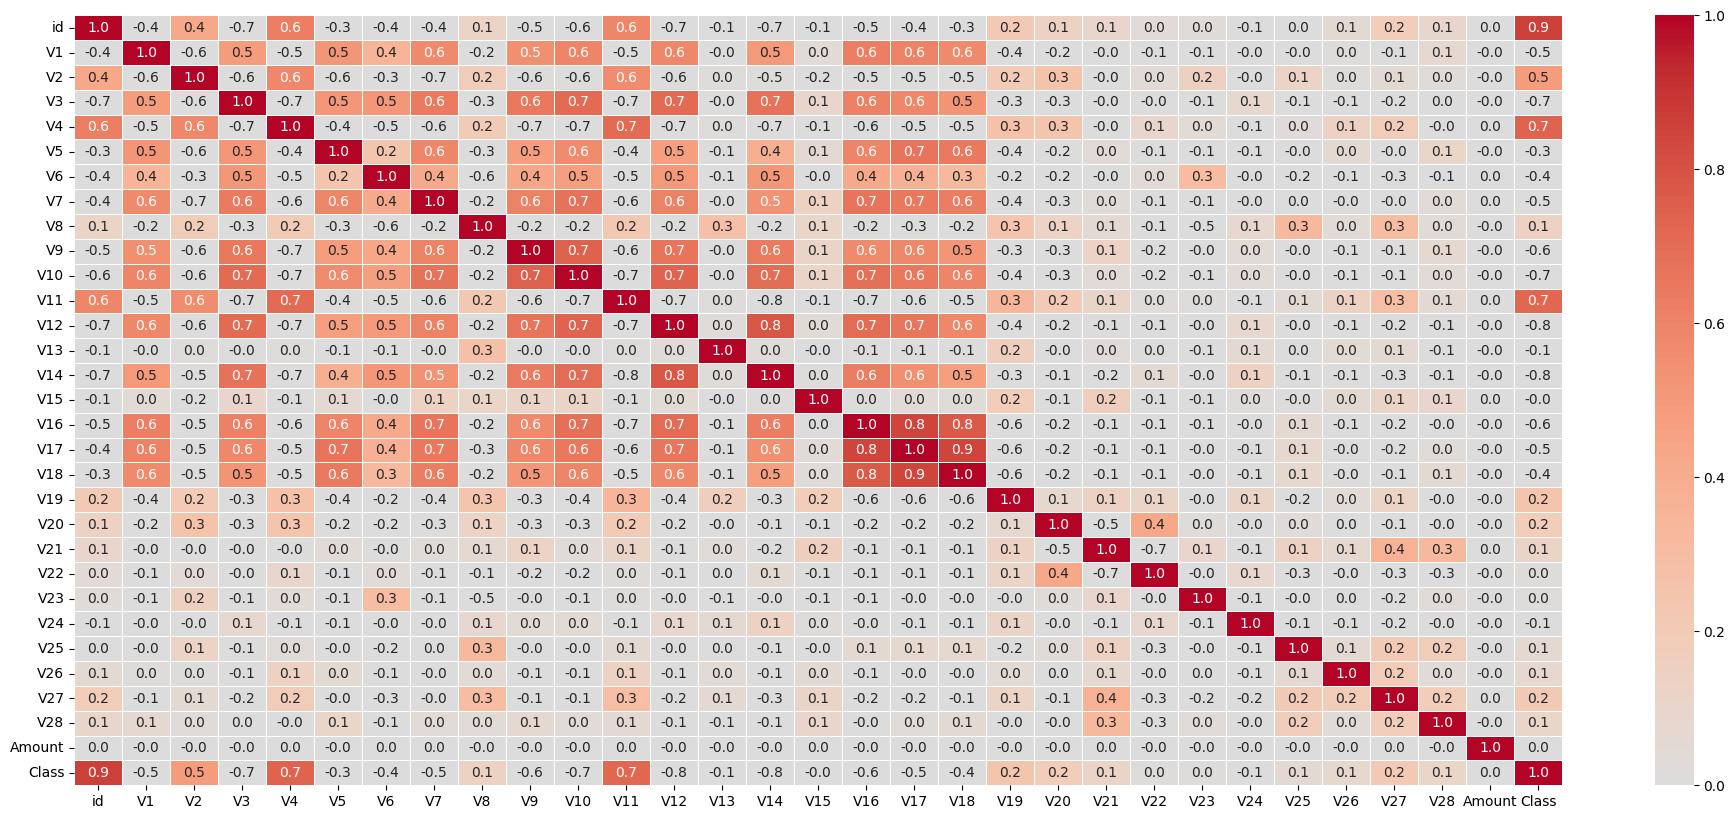

In [8]:
plt.figure(figsize=(24, 10))
sns.heatmap(df.corr(), cmap='coolwarm', center=0, annot=True, linewidths=0.7, vmin=0, vmax=1, fmt='.1f')
plt.show()


In [9]:
import numpy as np
import pandas as pd

n_missing = 60_000

cols = df.columns.difference(['id', 'Class'])

for col in cols:
    random_idx = np.random.choice(df.index, size=n_missing, replace=False)
    df.loc[random_idx, col] = np.nan


In [10]:
df.isna().sum().head(10)


,0
id,0
V1,60000
V2,60000
V3,60000
V4,60000
V5,60000
V6,60000
V7,60000
V8,60000
V9,60000


In [11]:
df['Class'].value_counts()


,count
Class,
0,284315
1,284315


In [12]:
# Class 0
class0 = df[df['Class'] == 0]
# Class 1
class1 = df[df['Class'] == 1]
# drop 10% من Class 0
drop_idx0 = class0.sample(frac=0.10, random_state=42).index

# drop 15% من Class 1
drop_idx1 = class1.sample(frac=0.15, random_state=42).index
df_dropped = df.drop(index=drop_idx0.union(drop_idx1))
df_dropped['Class'].value_counts()


,count
Class,
0,255883
1,241668


In [13]:
df=df_dropped.copy()

In [14]:
df.isna().sum().head(10)


,0
id,0
V1,52502
V2,52463
V3,52539
V4,52529
V5,52551
V6,52448
V7,52416
V8,52525
V9,52518



3️⃣ CORRELATION ANALYSIS

Top 10 Positive Correlations with Fraud:
id        0.864172
V4        0.735623
V11       0.724330
V2        0.492473
V19       0.245113
V27       0.213238
V20       0.180047
V8        0.145609
V21       0.110080
V28       0.102477
V26       0.070100
V25       0.061052
V22       0.015006
V23       0.010327
Amount    0.002666
Name: Class, dtype: float64

Top 10 Negative Correlations with Fraud:
V15   -0.038894
V13   -0.070936
V24   -0.129227
V5    -0.341237
V18   -0.411849
V6    -0.436759
V17   -0.481346
V7    -0.487670
V1    -0.505607
V16   -0.575660
V9    -0.586407
V10   -0.674687
V3    -0.682266
V12   -0.768774
V14   -0.805767
Name: Class, dtype: float64


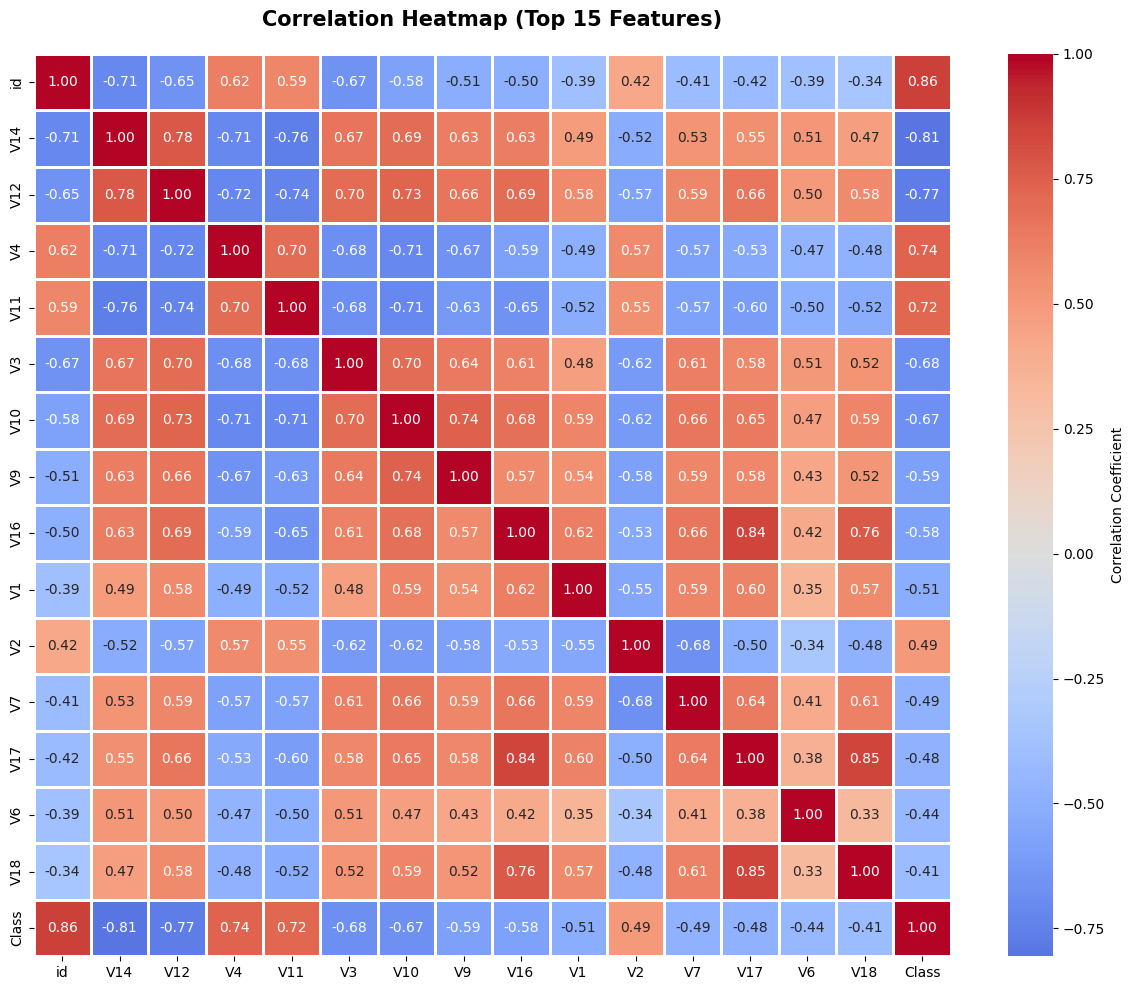

In [15]:
print("\n" + "="*60)
print("3️⃣ CORRELATION ANALYSIS")
print("="*60)

# Calculate correlation with target
correlations = df.corr()['Class'].drop('Class').sort_values(ascending=False)
print("\nTop 10 Positive Correlations with Fraud:")
print(correlations.head(15))
print("\nTop 10 Negative Correlations with Fraud:")
print(correlations.tail(15))

# Plot correlation heatmap for top features
top_features = correlations.abs().nlargest(15).index.tolist() + ['Class']
plt.figure(figsize=(12, 10))
sns.heatmap(df[top_features].corr(), annot=True, fmt='.2f',
            cmap='coolwarm', center=0, linewidths=1,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap (Top 15 Features)', fontsize=15, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [16]:
missing_values = df.isnull().sum().sum()
print(f"{missing_values} missing values found.")


duplicates = df.duplicated().sum()
print(f"{duplicates} duplicate rows found.")


df.drop('id', axis=1, inplace=True)
print("Dropped 'id' column.")


print(f"\nNew Shape after Cleaning: {df.shape}")

1522411 missing values found.
0 duplicate rows found.
Dropped 'id' column.

New Shape after Cleaning: (497551, 30)


In [17]:
X = df.drop('Class', axis=1)
Y = df['Class']
df=X

In [18]:
#replace nan and do simple imputer
imputer = SimpleImputer(strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)



In [19]:
df.isna().sum().head(10)


,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0
V10,0


In [20]:
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.985100,-0.356045,0.019320,-0.020931,0.277140,0.428605,0.014400,-0.133118,0.347452,0.529808,...,-0.233984,-0.194936,-0.605761,0.079469,-0.577395,-0.001309,0.296503,-0.006961,-0.064512,6531.37
1,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,...,0.361652,-0.005020,0.001217,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54
2,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,0.575231,...,-0.378223,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44
3,-0.206820,-0.165280,1.527053,-0.020931,0.106125,0.530549,0.658849,-0.212660,0.016277,0.968046,...,0.247237,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,-0.006961,-0.002775,14278.97
4,0.025302,-0.140514,1.191138,-0.707979,0.430490,0.458973,0.611050,-0.092629,0.180811,0.451788,...,-0.076400,-0.187739,-0.538518,-0.050465,-0.631553,-0.456480,0.252670,0.066681,0.095812,6901.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497546,-0.542349,0.585098,-0.547730,1.005465,-0.702046,-0.287417,-0.835174,0.382365,-1.281525,-0.950131,...,0.786416,0.463312,0.705032,-0.124074,0.046466,-0.196141,0.553614,1.222537,1.172982,10145.64
497547,0.013934,0.061886,-0.899794,0.904227,-1.002401,0.481454,-0.370393,0.189694,-0.938153,-1.161847,...,-0.751011,0.167503,0.419731,1.288249,0.004021,0.560661,-0.006018,3.308968,0.081564,4394.16
497548,0.013934,-0.004095,0.137526,-0.035893,-0.042291,0.121098,-0.070958,-0.019997,0.016277,-0.144495,...,-0.076417,0.140788,0.536523,-0.211100,-0.448909,0.540073,-0.755836,-0.487540,-0.268741,23572.85
497549,0.636871,-0.516970,-0.300889,-0.020931,0.131042,-0.294148,0.580568,-0.207723,0.893527,-0.080078,...,0.288186,-0.003780,-0.195609,-0.175488,-0.554643,-0.099669,-1.434931,-0.159269,-0.076251,10160.83


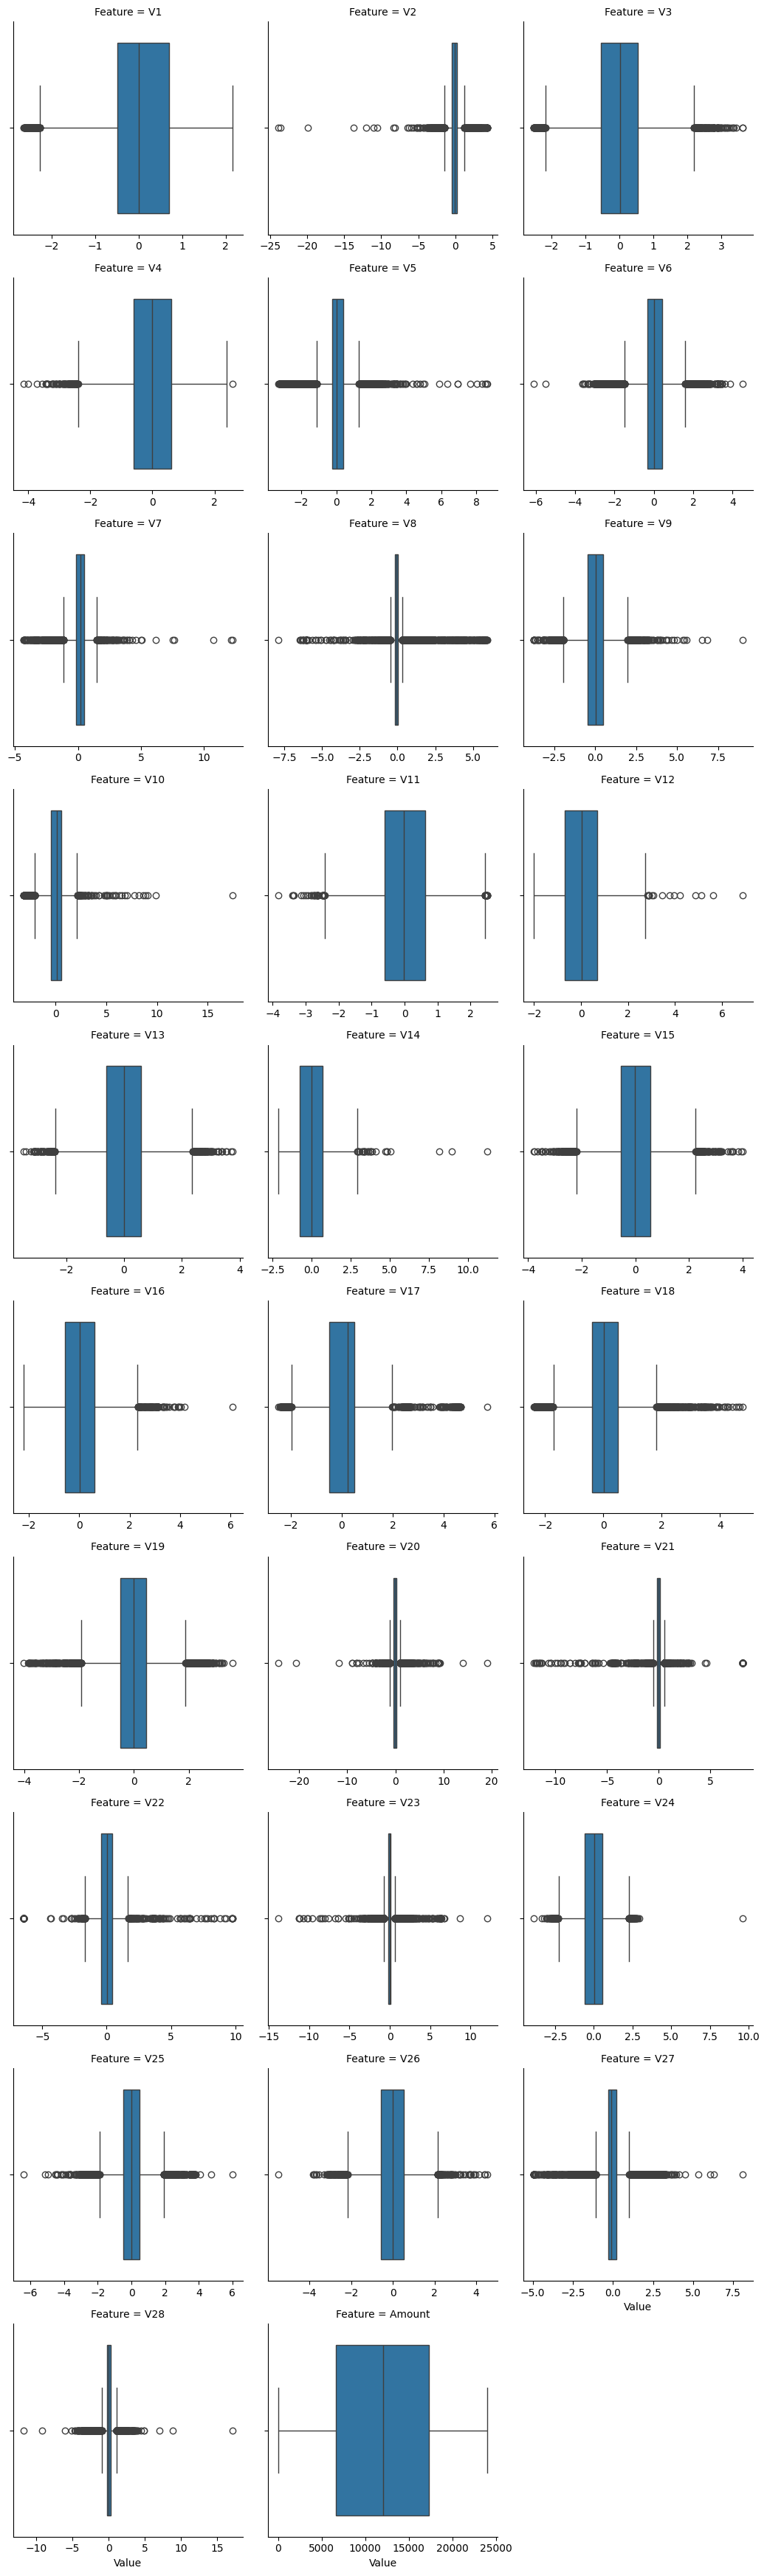

In [21]:
df_melted = df.sample(10000).melt(var_name='Feature', value_name='Value')

g = sns.FacetGrid(df_melted, col='Feature', col_wrap=3, sharex=False, sharey=False, height=3.5)
g.map(sns.boxplot, 'Value')
plt.show()

In [22]:
df_clip = df

for col in df_clip.select_dtypes(include='number').columns:
    Q1 = df_clip[col].quantile(0.25)
    Q3 = df_clip[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df_clip[col] = df_clip[col].clip(lower, upper)

In [23]:
df=df_clip.copy()

In [24]:
outlier_counts = {}

for col in df.select_dtypes(include='number').columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    count = df[(df[col] < lower) | (df[col] > upper)][col].count()
    outlier_counts[col] = count

# عرض العدد لكل عمود
for col, count in outlier_counts.items():
    print(f"{col} → {count} outliers")


V1 → 0 outliers
V2 → 0 outliers
V3 → 0 outliers
V4 → 0 outliers
V5 → 0 outliers
V6 → 0 outliers
V7 → 0 outliers
V8 → 0 outliers
V9 → 0 outliers
V10 → 0 outliers
V11 → 0 outliers
V12 → 0 outliers
V13 → 0 outliers
V14 → 0 outliers
V15 → 0 outliers
V16 → 0 outliers
V17 → 0 outliers
V18 → 0 outliers
V19 → 0 outliers
V20 → 0 outliers
V21 → 0 outliers
V22 → 0 outliers
V23 → 0 outliers
V24 → 0 outliers
V25 → 0 outliers
V26 → 0 outliers
V27 → 0 outliers
V28 → 0 outliers
Amount → 0 outliers


In [25]:
X_train, X_test, y_train, y_test = train_test_split(df, Y, test_size=0.2, random_state=42, stratify=Y)
print("\nData Split Info:")
print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")


Data Split Info:
Training Shape: (398040, 29)
Testing Shape: (99511, 29)


In [26]:
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


1️⃣ CLASS DISTRIBUTION ANALYSIS


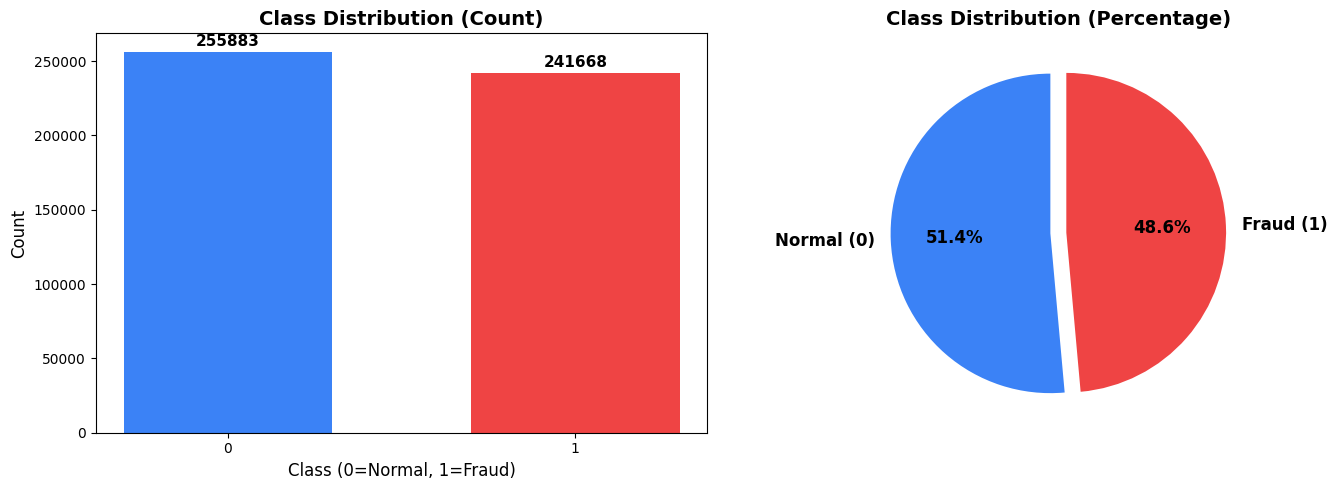


Class Distribution:
Class
0    255883
1    241668
Name: count, dtype: int64

Class Distribution (%):
Class
0    51.428497
1    48.571503
Name: proportion, dtype: float64


In [27]:
print("\n" + "="*60)
print("1️⃣ CLASS DISTRIBUTION ANALYSIS")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count Plot - استخدام matplotlib مباشرة
class_counts = Y.value_counts().sort_index()
axes[0].bar([0, 1], class_counts.values, color=['#3b82f6', '#ef4444'], width=0.6)
axes[0].set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class (0=Normal, 1=Fraud)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticks([0, 1])

# Add counts on bars
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + max(class_counts.values)*0.01, str(v),
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Pie Chart
colors = ['#3b82f6', '#ef4444']
explode = (0.05, 0.05)
axes[1].pie(class_counts, labels=['Normal (0)', 'Fraud (1)'],
            autopct='%1.1f%%', colors=colors, explode=explode,
            startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nClass Distribution:")
print(Y.value_counts())
print(f"\nClass Distribution (%):")
print(Y.value_counts(normalize=True) * 100)

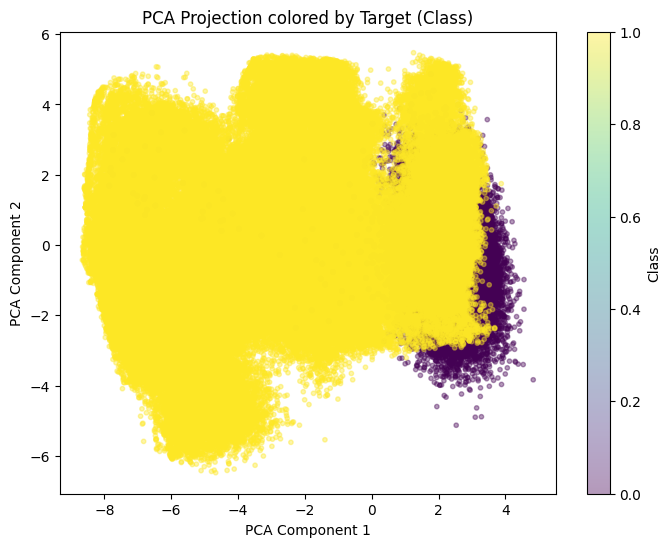

In [28]:
from sklearn.decomposition import PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=Y,
    alpha=0.4,
    s=10
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection colored by Target (Class)")
plt.colorbar(scatter, label="Class")
plt.show()


Best K = 2

Train Accuracy: 0.9995327102803738
Test Accuracy: 0.995146265237009

Confusion Matrix:
 [[50785   392]
 [   91 48243]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     51177
           1       0.99      1.00      1.00     48334

    accuracy                           1.00     99511
   macro avg       1.00      1.00      1.00     99511
weighted avg       1.00      1.00      1.00     99511



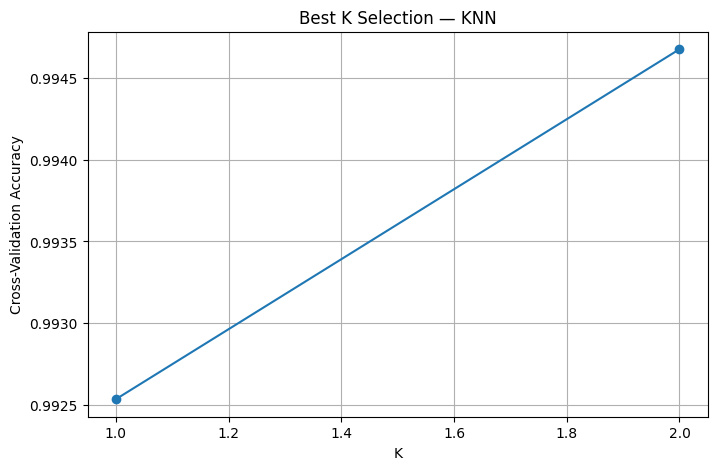

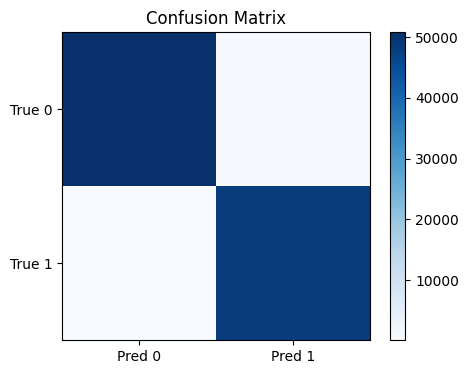

In [29]:

import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

k_values = range(1, 3)
cv_scores = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, X_train ,y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

best_k = k_values[np.argmax(cv_scores)]
print("Best K =", best_k)


best_model = KNeighborsClassifier(n_neighbors=best_k)
best_model.fit(X_train, y_train)

# Prediction
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)


#evaluation
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

cm = confusion_matrix(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred)

print("\nTrain Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

# ===================================================
# 5) Plots
# ===================================================

# Plot CV Accuracy vs K
plt.figure(figsize=(8,5))
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel("K")
plt.ylabel("Cross-Validation Accuracy")
plt.title("Best K Selection — KNN")
plt.grid(True)
plt.show()

# Confusion Matrix Heatmap
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0,1], ["Pred 0", "Pred 1"])
plt.yticks([0,1], ["True 0", "True 1"])
plt.show()
